In [1]:
import numpy as np
# left 3d pose 
left_kpt_3d_f = np.load("/workspace/code/logs/pose3d/2025-11-07/12-28-29/run_3/videopose3d/left/osmo_1.npy")
# right 3d pose
right_kpt_3d_f = np.load("/workspace/code/logs/pose3d/2025-11-07/12-28-29/run_3/videopose3d/right/osmo_2.npy")

In [2]:
left_kpt_3d_f.shape, right_kpt_3d_f.shape

((360, 17, 3), (360, 17, 3))

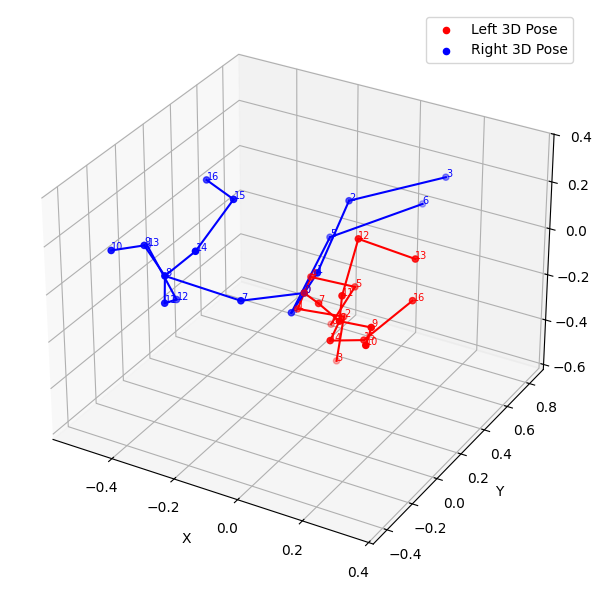

In [3]:
# draw left and right 3d pose in one plot 
# 连线


H36M17_EDGES = [
    (0, 1),
    (1, 2),
    (2, 3),  # Hip->RLeg
    (0, 4),
    (4, 5),
    (5, 6),  # Hip->LLeg
    (0, 7),
    (7, 8),
    (8, 9),
    (9, 10),  # Spine->Head
    (8, 11),
    (11, 12),
    (12, 13),  # Thorax->LArm
    (8, 14),
    (14, 15),
    (15, 16),  # Thorax->RArm
]

import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(left_kpt_3d_f[0, :, 0], left_kpt_3d_f[0, :, 1], left_kpt_3d_f[0, :, 2], c='r', label='Left 3D Pose')
ax.scatter(right_kpt_3d_f[0, :, 0], right_kpt_3d_f[0, :, 1], right_kpt_3d_f[0, :, 2], c='b', label='Right 3D Pose')

for a, b in H36M17_EDGES:
        ax.plot([left_kpt_3d_f[0, a, 0], left_kpt_3d_f[0, b, 0]],
                [left_kpt_3d_f[0, a, 1], left_kpt_3d_f[0, b, 1]],
                [left_kpt_3d_f[0, a, 2], left_kpt_3d_f[0, b, 2]], c='r')
        ax.plot([right_kpt_3d_f[0, a, 0], right_kpt_3d_f[0, b, 0]],
                [right_kpt_3d_f[0, a, 1], right_kpt_3d_f[0, b, 1]],
                [right_kpt_3d_f[0, a, 2], right_kpt_3d_f[0, b, 2]], c='b')
        
# 标注点的索引
for i, (xi, yi, zi) in enumerate(zip(left_kpt_3d_f[0, :, 0], left_kpt_3d_f[0, :, 1], left_kpt_3d_f[0, :, 2])):
    ax.text(xi, yi, zi, f"{i}", color="red", fontsize=7)

for i, (xi, yi, zi) in enumerate(zip(right_kpt_3d_f[0, :, 0], right_kpt_3d_f[0, :, 1], right_kpt_3d_f[0, :, 2])):
    ax.text(xi, yi, zi, f"{i}", color="blue", fontsize=7)



ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.legend()
fig.tight_layout()
plt.show()      

In [4]:
import numpy as np
from typing import Tuple, Literal

# H36M-17 索引
HIP, THORAX, NECK = 0, 8, 9
L_HIP, R_HIP = 4, 1
L_SHO, R_SHO = 11, 14

def _nan_mean(points: np.ndarray, axis=0):
    m = np.nanmean(points, axis=axis)
    return m

def _midpoint(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return (a + b) * 0.5

def _unit(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    return v / (n + 1e-12)

def _rotation_from_u_to_v(u: np.ndarray, v: np.ndarray) -> np.ndarray:
    """返回把向量 u 旋到 v 的 3x3 旋转矩阵（罗德里格公式），u/v 不必单位。"""
    u = _unit(u); v = _unit(v)
    c = float(np.clip(u @ v, -1.0, 1.0))
    if c > 1 - 1e-10:
        return np.eye(3)
    if c < -1 + 1e-10:
        # 反向，找一条与u不共线的轴
        axis = _unit(np.cross(u, np.array([1.0, 0.0, 0.0])))
        if not np.isfinite(axis).all() or np.linalg.norm(axis) < 1e-8:
            axis = _unit(np.cross(u, np.array([0.0, 1.0, 0.0])))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        return np.eye(3) + 2*K@K  # 180°
    axis = _unit(np.cross(u, v))
    s = np.linalg.norm(np.cross(u, v))
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    return np.eye(3) + K*s + K@K*((1-c)/(s**2 + 1e-12))

def robust_center_scale_h36m(
    X: np.ndarray,
    scale_mode: Literal["mean","rms"]="mean",
    align_up: bool = False,
    up_axis: Literal["y","z"] = "y",
    blend_pelvis0: float = 0.3,
) -> Tuple[np.ndarray, float, dict]:
    """
    更稳健的 H36M 规范化：
      - 平移到骨盆中心（左右髋中点与第0点加权）
      - 用多条躯干骨段估计尺度
      - 可选把 (neck - pelvis) 对齐到 +Y 或 +Z 方向

    Args:
      X: (17,3)
      scale_mode: 'mean' 或 'rms' 作为骨段长度汇聚方式
      align_up: 是否对齐身体上方向
      up_axis: 'y' 或 'z'，上方向对齐到哪个轴
      blend_pelvis0: pelvis_center = (1-blend)*mid(LHip,RHip) + blend*joint0

    Returns:
      Xn: 规范化后的 (17,3)
      s: 使用的尺度
      info: 诊断信息字典
    """
    X = X.astype(float).copy()
    assert X.shape == (17,3)

    # ---- 估计骨盆中心（更稳）----
    pts = {}
    def safe(pidx): 
        v = X[pidx]; 
        return v if np.isfinite(v).all() else np.array([np.nan,np.nan,np.nan])
    pts["pelvis0"] = safe(HIP)
    pts["LHip"] = safe(L_HIP)
    pts["RHip"] = safe(R_HIP)
    pts["neck"] = safe(NECK)
    pts["thorax"] = safe(THORAX)
    pts["LShoulder"] = safe(L_SHO)
    pts["RShoulder"] = safe(R_SHO)

    pelvis_lr = _midpoint(pts["LHip"], pts["RHip"])
    if not np.isfinite(pelvis_lr).all():
        # 退化：只能用第0点
        pelvis_center = pts["pelvis0"]
    elif not np.isfinite(pts["pelvis0"]).all():
        pelvis_center = pelvis_lr
    else:
        pelvis_center = (1.0 - blend_pelvis0)*pelvis_lr + blend_pelvis0*pts["pelvis0"]

    # ---- 稳健的“颈/上躯干代表点”----
    shoulders_mid = _midpoint(pts["LShoulder"], pts["RShoulder"])
    neck_candidates = []
    for p in [pts["neck"], pts["thorax"], shoulders_mid]:
        if np.isfinite(p).all(): neck_candidates.append(p)
    if len(neck_candidates)==0:
        # 兜底：用 pelvis 向上 + 一个小偏移，避免 s=0
        neck_rep = pelvis_center + np.array([0, 1.0, 0])
    else:
        neck_rep = _nan_mean(np.vstack(neck_candidates), axis=0)

    # ---- 平移到骨盆中心 ----
    X -= pelvis_center

    # ---- 稳健尺度：多条躯干骨段 ----
    segs = []
    # pelvis↔neck
    if np.isfinite(neck_rep).all():
        segs.append(neck_rep)  # 实际就是 |neck_rep - pelvis_center|，平移后 = |neck_rep|
    # LHip↔LShoulder, RHip↔RShoulder
    for h, s in [(pts["LHip"], pts["LShoulder"]), (pts["RHip"], pts["RShoulder"])]:
        if np.isfinite(h).all() and np.isfinite(s).all():
            segs.append(s - h)

    seg_lens = [np.linalg.norm(v) for v in segs if np.isfinite(v).all()]
    if len(seg_lens)==0:
        s = 1.0  # 最后兜底
    else:
        if scale_mode=="rms":
            s = np.sqrt(np.mean(np.square(seg_lens)))
        else:
            s = float(np.mean(seg_lens))
        if s < 1e-8: s = 1.0
    X /= s

    # ---- 可选：把上方向对齐到指定轴（便于对比/可视化）----
    R_align = np.eye(3)
    if align_up:
        up_vec = neck_rep - pelvis_center
        target = np.array([0,1,0]) if up_axis=="y" else np.array([0,0,1])
        if np.isfinite(up_vec).all() and np.linalg.norm(up_vec) > 1e-6:
            R_align = _rotation_from_u_to_v(up_vec, target)
            X = (R_align @ X.T).T

    info = {
        "pelvis_center": pelvis_center,
        "neck_rep": neck_rep,
        "scale": s,
        "R_align": R_align,
        "used_segments": len(seg_lens),
    }
    return X, s, info

# 单帧
Lt_n, s, info = robust_center_scale_h36m(
    left_kpt_3d_f[0], 
    scale_mode="mean", 
    align_up=True, 
    up_axis="y"
)

Rt_n, s, info = robust_center_scale_h36m(
    right_kpt_3d_f[0], 
    scale_mode="mean", 
    align_up=True, 
    up_axis="y"
)   



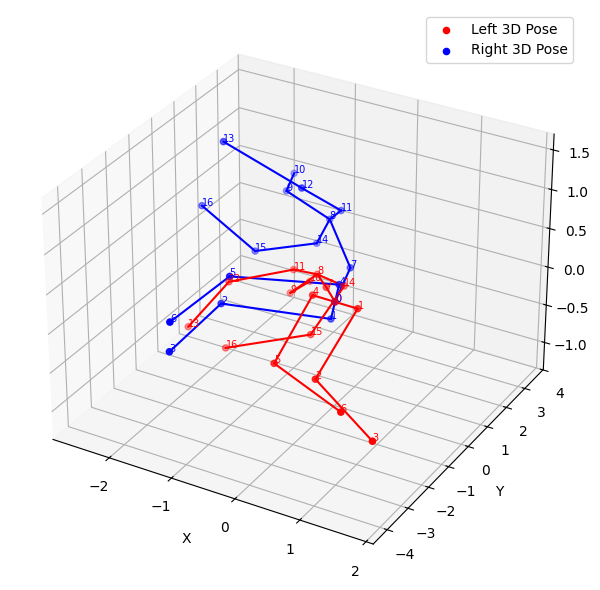

In [5]:

Rt_n[:, 0] *= -1  # mirror x axis
# Rt_n[:, 1] *= -1  # flip y axis
Rt_n[:, 2] *= -1  # flip z axis

# draw left and right 3d pose in one plot 
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Lt_n[:, 0], Lt_n[:, 1], Lt_n[:, 2], c='r', label='Left 3D Pose')
ax.scatter(Rt_n[:, 0], Rt_n[:, 1], Rt_n[:, 2], c='b', label='Right 3D Pose')


for a, b in H36M17_EDGES:
    ax.plot([Lt_n[a, 0], Lt_n[b, 0]],
            [Lt_n[a, 1], Lt_n[b, 1]],
            [Lt_n[a, 2], Lt_n[b, 2]], c='r')
    ax.plot([Rt_n[a, 0], Rt_n[b, 0]],
            [Rt_n[a, 1], Rt_n[b, 1]],
            [Rt_n[a, 2], Rt_n[b, 2]], c='b')
        
# 标注点的索引
for i, (xi, yi, zi) in enumerate(zip(Lt_n[:, 0], Lt_n[:, 1], Lt_n[:, 2])):
    ax.text(xi, yi, zi, f"{i}", color="red", fontsize=7)

for i, (xi, yi, zi) in enumerate(zip(Rt_n[:, 0], Rt_n[:, 1], Rt_n[:, 2])):
    ax.text(xi, yi, zi, f"{i}", color="blue", fontsize=7)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.legend()
fig.tight_layout()
plt.show()      

/tmp/ipykernel_478224/2351710882.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


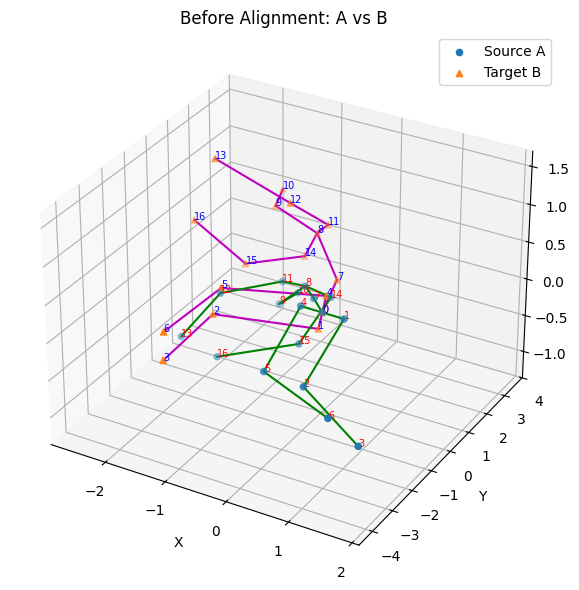

/tmp/ipykernel_478224/2351710882.py:102: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


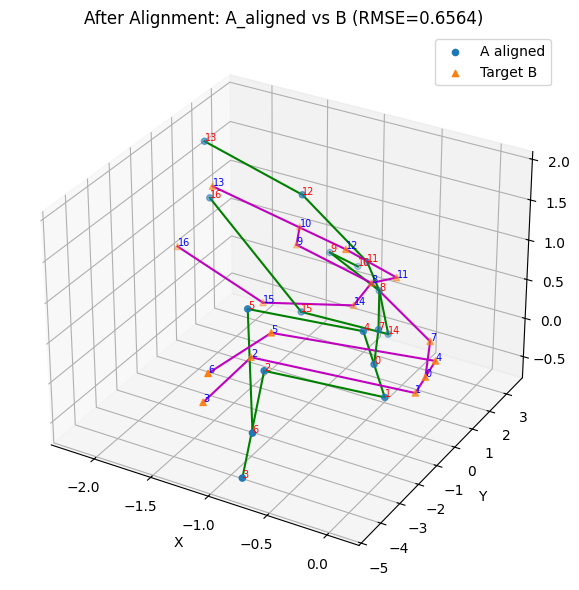

('3d_alignment_transform.json',
 {'rotation_matrix': [[0.3058013723461662,
    0.1656373237260833,
    0.9375765556262924],
   [-0.3176383937560859, 0.94608072329706, -0.0635383019742061],
   [-0.8975474201863962, -0.27838021121224155, 0.34192555698890414]],
  'translation': [-0.36522263554639, -0.4587419783206651, 0.10363065386485892],
  'homogeneous_T_4x4': [[0.3058013723461662,
    0.1656373237260833,
    0.9375765556262924,
    -0.36522263554639],
   [-0.3176383937560859,
    0.94608072329706,
    -0.0635383019742061,
    -0.4587419783206651],
   [-0.8975474201863962,
    -0.27838021121224155,
    0.34192555698890414,
    0.10363065386485892],
   [0.0, 0.0, 0.0, 1.0]],
  'rmse': 0.6564140725758217})

In [6]:
# Visualization of 3D point set alignment with Kabsch (SVD) in NumPy
import numpy as np
import json
import matplotlib.pyplot as plt

# ---------- 1) Helper: rigid transform via SVD (Kabsch) ----------
def rigid_transform_3D(A, B):
    """
    Compute R, t that aligns Nx3 points A to B (minimizing least squares).
    Returns rotation matrix R (3x3) and translation t (3,).
    """
    assert A.shape == B.shape and A.shape[1] == 3

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = AA.T @ BB
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B - R @ centroid_A
    return R, t

# ---------- 2) Create a synthetic example ----------

A = Lt_n  # Source points (Nx3)
N = A.shape[0]

# Ground-truth transform: rotate around z + translate
B = Rt_n  # Target points (Nx3)

# ---------- 3) Recover transform and align ----------
R, t = rigid_transform_3D(A, B)
A_aligned = (A @ R.T) + t

# Also compute alignment error (RMSE)
rmse = np.sqrt(np.mean(np.sum((A_aligned - B)**2, axis=1)))

# ---------- 4) Plot BEFORE alignment ----------
fig1 = plt.figure(figsize=(6, 6))
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(A[:,0], A[:,1], A[:,2], label='Source A', marker='o')
ax1.scatter(B[:,0], B[:,1], B[:,2], label='Target B', marker='^')


for a, b in H36M17_EDGES:
    ax1.plot([A[a, 0], A[b, 0]],
            [A[a, 1], A[b, 1]],
            [A[a, 2], A[b, 2]], c='g')
    ax1.plot([B[a, 0], B[b, 0]],
            [B[a, 1], B[b, 1]],
            [B[a, 2], B[b, 2]], c='m')
    
     
# 标注点的索引
for i, (xi, yi, zi) in enumerate(zip(A[:, 0], A[:, 1], A[:, 2])):
    ax1.text(xi, yi, zi, f"{i}", color="red", fontsize=7)

for i, (xi, yi, zi) in enumerate(zip(B[:, 0], B[:, 1], B[:, 2])):
    ax1.text(xi, yi, zi, f"{i}", color="blue", fontsize=7)

ax1.set_title('Before Alignment: A vs B')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.legend()
fig1.tight_layout()
fig1.show()
plt.show()

# ---------- 5) Plot AFTER alignment ----------
fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(A_aligned[:,0], A_aligned[:,1], A_aligned[:,2], label='A aligned', marker='o')
ax2.scatter(B[:,0], B[:,1], B[:,2], label='Target B', marker='^')


for a, b in H36M17_EDGES:
    ax2.plot([A_aligned[a, 0], A_aligned[b, 0]],
            [A_aligned[a, 1], A_aligned[b, 1]],
            [A_aligned[a, 2], A_aligned[b, 2]], c='g')
    ax2.plot([B[a, 0], B[b, 0]],
            [B[a, 1], B[b, 1]],
            [B[a, 2], B[b, 2]], c='m')
    
# 标注点的索引
for i, (xi, yi, zi) in enumerate(zip(A_aligned[:, 0], A_aligned[:, 1], A_aligned[:, 2])):
    ax2.text(xi, yi, zi, f"{i}", color="red", fontsize=7)

for i, (xi, yi, zi) in enumerate(zip(B[:, 0], B[:, 1], B[:, 2])):
    ax2.text(xi, yi, zi, f"{i}", color="blue", fontsize=7)

ax2.set_title(f'After Alignment: A_aligned vs B (RMSE={rmse:.4f})')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.legend()
fig2.tight_layout()
fig2.show()
plt.show()

# ---------- 6) Save recovered transform to JSON ----------
T = np.eye(4)
T[:3,:3] = R
T[:3, 3] = t
transform_info = {
    "rotation_matrix": R.tolist(),
    "translation": t.tolist(),
    "homogeneous_T_4x4": T.tolist(),
    "rmse": float(rmse)
}
json_path = "3d_alignment_transform.json"
with open(json_path, "w") as f:
    json.dump(transform_info, f, indent=2)

json_path, transform_info


In [7]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot

# 1) 旋转质检
orth_err = np.linalg.norm(R.T @ R - np.eye(3))
detR = np.linalg.det(R)

# 2) 欧拉角 & 轴角
rot = Rot.from_matrix(R)
euler_zyx_deg = rot.as_euler('zyx', degrees=True)  # [yaw, pitch, roll]
rotvec = rot.as_rotvec()
axis = rotvec / (np.linalg.norm(rotvec) + 1e-12)
angle_deg = np.linalg.norm(rotvec) * 180/np.pi

print(f"orth_err={orth_err:.2e}, detR={detR:.6f}")
print(f"Euler[zyx](deg)={euler_zyx_deg}")
print(f"Axis={axis}, Angle(deg)={angle_deg:.2f}")

# 3) 点变换
# X_A: (N,3)
# X_B = (R @ X_A.T).T + t


orth_err=7.05e-16, detR=1.000000
Euler[zyx](deg)=[-28.44219182  69.64847382  10.52691379]
Axis=[-0.11249358  0.96089108 -0.25304848], Angle(deg)=72.73
